### Edgar Moises Hernandez-Gonzalez
#### 14/05/20-19/05/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Resize proporcional de 352x125
##### Validacion cruzada

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense, Dropout)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA09E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

In [8]:
print(x.shape)
print(y.shape)

(576, 22000)
(576, 1)


In [9]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 576


In [10]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 4


In [11]:
# codificar etiquetas con valores de 0 a nClases-1
y = LabelEncoder().fit_transform(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (125, 352) #ancho, alto
  datos = np.zeros((576,352,125))
  temporal = np.zeros((2816,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [13]:
#llamar a unir_escalogramas_vertical_resize(data)
x = unir_escalogramas_vertical_resize(x)

0
100
200
300
400
500


In [14]:
print(x.shape)

(576, 352, 125)


In [15]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

158.27665508009505
0.001533027630540136
7.09086606925344


In [0]:
#convertir a float
x = x.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [17]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.9954507
9.641683e-06
0.04459666


In [18]:
#convertir de 3D a 5D
x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], 1))

print(x.shape)

(576, 1, 352, 125, 1)


In [0]:
mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CNN2D_LSTM_CWT09_CV.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
skf = StratifiedKFold(n_splits = 10)

In [0]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(16, activation='tanh', dropout=0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1

Epoch 00001: val_accuracy improved from -inf to 0.25862, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CNN2D_LSTM_CWT09_CV.hdf5

Epoch 00002: val_accuracy did not improve from 0.25862

Epoch 00003: val_accuracy did not improve from 0.25862

Epoch 00004: val_accuracy did not improve from 0.25862

Epoch 00005: val_accuracy did not improve from 0.25862

Epoch 00006: val_accuracy did not improve from 0.25862

Epoch 00007: val_accuracy did not improve from 0.25862

Epoch 00008: val_accuracy did not improve from 0.25862

Epoch 00009: val_accuracy did not improve from 0.25862

Epoch 00010: val_accuracy did not improve from 0.25862

Epoch 00011: val_accuracy did not improve from 0.25862

Epoch 00012: val_accuracy did not improve from 0.25862

Epoch 00013: val_accuracy did not improve from 0.25862

Epoch 00014: val_accuracy did not improve from 0.25862

Epoch 00015: val_accuracy did not improve from 0.25862

Epoch 00016: val_accuracy did not improve from 0.2586

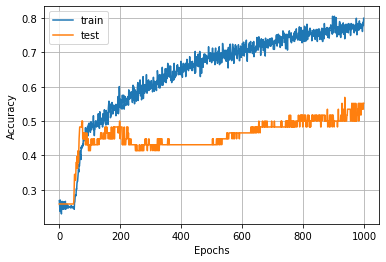

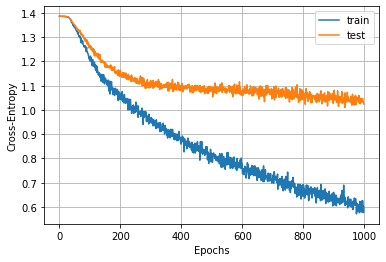


Iteration: 2

Epoch 00001: val_accuracy did not improve from 0.56897

Epoch 00002: val_accuracy did not improve from 0.56897

Epoch 00003: val_accuracy did not improve from 0.56897

Epoch 00004: val_accuracy did not improve from 0.56897

Epoch 00005: val_accuracy did not improve from 0.56897

Epoch 00006: val_accuracy did not improve from 0.56897

Epoch 00007: val_accuracy did not improve from 0.56897

Epoch 00008: val_accuracy did not improve from 0.56897

Epoch 00009: val_accuracy did not improve from 0.56897

Epoch 00010: val_accuracy did not improve from 0.56897

Epoch 00011: val_accuracy did not improve from 0.56897

Epoch 00012: val_accuracy did not improve from 0.56897

Epoch 00013: val_accuracy did not improve from 0.56897

Epoch 00014: val_accuracy did not improve from 0.56897

Epoch 00015: val_accuracy did not improve from 0.56897

Epoch 00016: val_accuracy did not improve from 0.56897

Epoch 00017: val_accuracy did not improve from 0.56897

Epoch 00018: val_accuracy did not

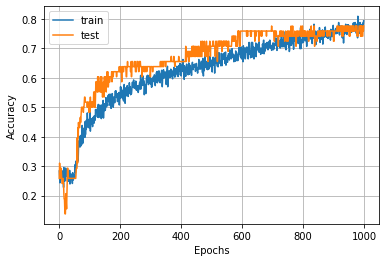

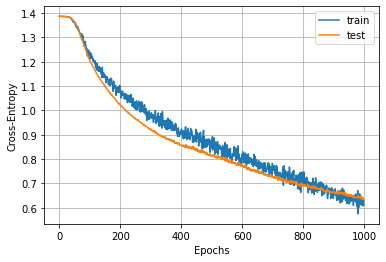


Iteration: 3

Epoch 00001: val_accuracy did not improve from 0.77586

Epoch 00002: val_accuracy did not improve from 0.77586

Epoch 00003: val_accuracy did not improve from 0.77586

Epoch 00004: val_accuracy did not improve from 0.77586

Epoch 00005: val_accuracy did not improve from 0.77586

Epoch 00006: val_accuracy did not improve from 0.77586

Epoch 00007: val_accuracy did not improve from 0.77586

Epoch 00008: val_accuracy did not improve from 0.77586

Epoch 00009: val_accuracy did not improve from 0.77586

Epoch 00010: val_accuracy did not improve from 0.77586

Epoch 00011: val_accuracy did not improve from 0.77586

Epoch 00012: val_accuracy did not improve from 0.77586

Epoch 00013: val_accuracy did not improve from 0.77586

Epoch 00014: val_accuracy did not improve from 0.77586

Epoch 00015: val_accuracy did not improve from 0.77586

Epoch 00016: val_accuracy did not improve from 0.77586

Epoch 00017: val_accuracy did not improve from 0.77586

Epoch 00018: val_accuracy did not

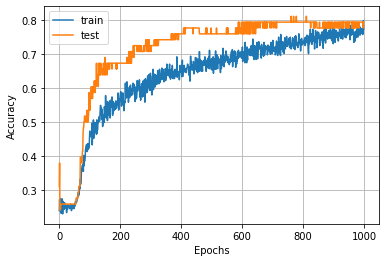

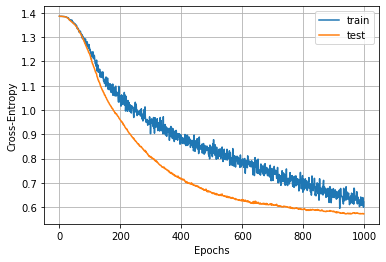


Iteration: 4

Epoch 00001: val_accuracy did not improve from 0.81034

Epoch 00002: val_accuracy did not improve from 0.81034

Epoch 00003: val_accuracy did not improve from 0.81034

Epoch 00004: val_accuracy did not improve from 0.81034

Epoch 00005: val_accuracy did not improve from 0.81034

Epoch 00006: val_accuracy did not improve from 0.81034

Epoch 00007: val_accuracy did not improve from 0.81034

Epoch 00008: val_accuracy did not improve from 0.81034

Epoch 00009: val_accuracy did not improve from 0.81034

Epoch 00010: val_accuracy did not improve from 0.81034

Epoch 00011: val_accuracy did not improve from 0.81034

Epoch 00012: val_accuracy did not improve from 0.81034

Epoch 00013: val_accuracy did not improve from 0.81034

Epoch 00014: val_accuracy did not improve from 0.81034

Epoch 00015: val_accuracy did not improve from 0.81034

Epoch 00016: val_accuracy did not improve from 0.81034

Epoch 00017: val_accuracy did not improve from 0.81034

Epoch 00018: val_accuracy did not

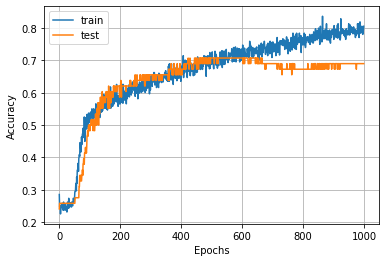

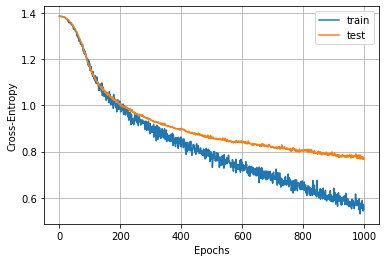


Iteration: 5

Epoch 00001: val_accuracy did not improve from 0.81034

Epoch 00002: val_accuracy did not improve from 0.81034

Epoch 00003: val_accuracy did not improve from 0.81034

Epoch 00004: val_accuracy did not improve from 0.81034

Epoch 00005: val_accuracy did not improve from 0.81034

Epoch 00006: val_accuracy did not improve from 0.81034

Epoch 00007: val_accuracy did not improve from 0.81034

Epoch 00008: val_accuracy did not improve from 0.81034

Epoch 00009: val_accuracy did not improve from 0.81034

Epoch 00010: val_accuracy did not improve from 0.81034

Epoch 00011: val_accuracy did not improve from 0.81034

Epoch 00012: val_accuracy did not improve from 0.81034

Epoch 00013: val_accuracy did not improve from 0.81034

Epoch 00014: val_accuracy did not improve from 0.81034

Epoch 00015: val_accuracy did not improve from 0.81034

Epoch 00016: val_accuracy did not improve from 0.81034

Epoch 00017: val_accuracy did not improve from 0.81034

Epoch 00018: val_accuracy did not

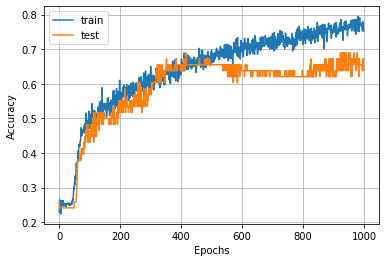

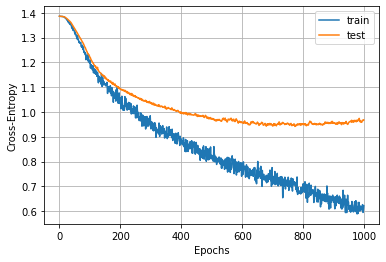


Iteration: 6

Epoch 00001: val_accuracy did not improve from 0.81034

Epoch 00002: val_accuracy did not improve from 0.81034

Epoch 00003: val_accuracy did not improve from 0.81034

Epoch 00004: val_accuracy did not improve from 0.81034

Epoch 00005: val_accuracy did not improve from 0.81034

Epoch 00006: val_accuracy did not improve from 0.81034

Epoch 00007: val_accuracy did not improve from 0.81034

Epoch 00008: val_accuracy did not improve from 0.81034

Epoch 00009: val_accuracy did not improve from 0.81034

Epoch 00010: val_accuracy did not improve from 0.81034

Epoch 00011: val_accuracy did not improve from 0.81034

Epoch 00012: val_accuracy did not improve from 0.81034

Epoch 00013: val_accuracy did not improve from 0.81034

Epoch 00014: val_accuracy did not improve from 0.81034

Epoch 00015: val_accuracy did not improve from 0.81034

Epoch 00016: val_accuracy did not improve from 0.81034

Epoch 00017: val_accuracy did not improve from 0.81034

Epoch 00018: val_accuracy did not

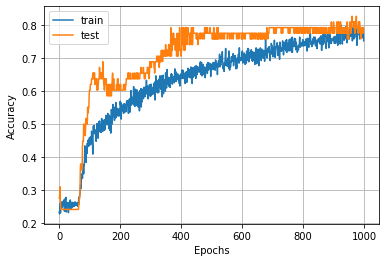

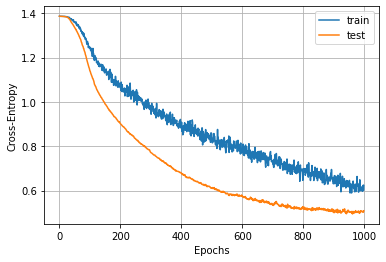


Iteration: 7

Epoch 00001: val_accuracy did not improve from 0.82759

Epoch 00002: val_accuracy did not improve from 0.82759

Epoch 00003: val_accuracy did not improve from 0.82759

Epoch 00004: val_accuracy did not improve from 0.82759

Epoch 00005: val_accuracy did not improve from 0.82759

Epoch 00006: val_accuracy did not improve from 0.82759

Epoch 00007: val_accuracy did not improve from 0.82759

Epoch 00008: val_accuracy did not improve from 0.82759

Epoch 00009: val_accuracy did not improve from 0.82759

Epoch 00010: val_accuracy did not improve from 0.82759

Epoch 00011: val_accuracy did not improve from 0.82759

Epoch 00012: val_accuracy did not improve from 0.82759

Epoch 00013: val_accuracy did not improve from 0.82759

Epoch 00014: val_accuracy did not improve from 0.82759

Epoch 00015: val_accuracy did not improve from 0.82759

Epoch 00016: val_accuracy did not improve from 0.82759

Epoch 00017: val_accuracy did not improve from 0.82759

Epoch 00018: val_accuracy did not

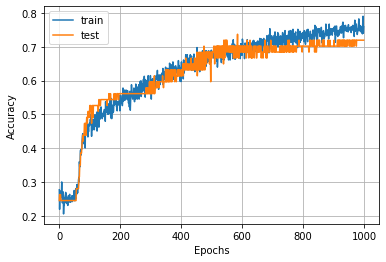

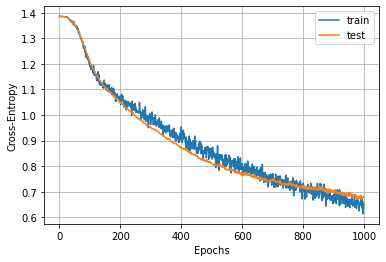


Iteration: 8

Epoch 00001: val_accuracy did not improve from 0.82759

Epoch 00002: val_accuracy did not improve from 0.82759

Epoch 00003: val_accuracy did not improve from 0.82759

Epoch 00004: val_accuracy did not improve from 0.82759

Epoch 00005: val_accuracy did not improve from 0.82759

Epoch 00006: val_accuracy did not improve from 0.82759

Epoch 00007: val_accuracy did not improve from 0.82759

Epoch 00008: val_accuracy did not improve from 0.82759

Epoch 00009: val_accuracy did not improve from 0.82759

Epoch 00010: val_accuracy did not improve from 0.82759

Epoch 00011: val_accuracy did not improve from 0.82759

Epoch 00012: val_accuracy did not improve from 0.82759

Epoch 00013: val_accuracy did not improve from 0.82759

Epoch 00014: val_accuracy did not improve from 0.82759

Epoch 00015: val_accuracy did not improve from 0.82759

Epoch 00016: val_accuracy did not improve from 0.82759

Epoch 00017: val_accuracy did not improve from 0.82759

Epoch 00018: val_accuracy did not

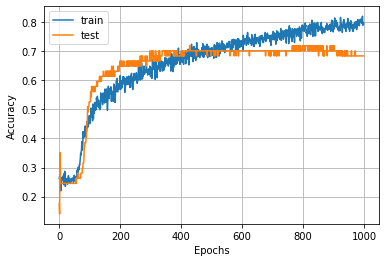

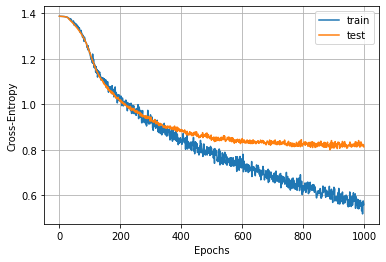


Iteration: 9

Epoch 00001: val_accuracy did not improve from 0.82759

Epoch 00002: val_accuracy did not improve from 0.82759

Epoch 00003: val_accuracy did not improve from 0.82759

Epoch 00004: val_accuracy did not improve from 0.82759

Epoch 00005: val_accuracy did not improve from 0.82759

Epoch 00006: val_accuracy did not improve from 0.82759

Epoch 00007: val_accuracy did not improve from 0.82759

Epoch 00008: val_accuracy did not improve from 0.82759

Epoch 00009: val_accuracy did not improve from 0.82759

Epoch 00010: val_accuracy did not improve from 0.82759

Epoch 00011: val_accuracy did not improve from 0.82759

Epoch 00012: val_accuracy did not improve from 0.82759

Epoch 00013: val_accuracy did not improve from 0.82759

Epoch 00014: val_accuracy did not improve from 0.82759

Epoch 00015: val_accuracy did not improve from 0.82759

Epoch 00016: val_accuracy did not improve from 0.82759

Epoch 00017: val_accuracy did not improve from 0.82759

Epoch 00018: val_accuracy did not

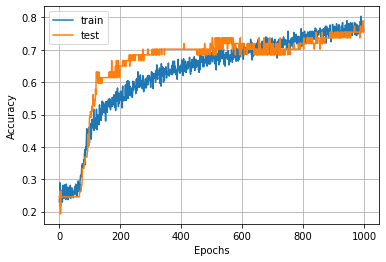

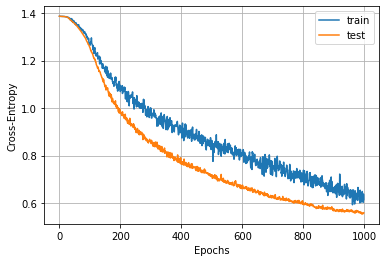


Iteration: 10

Epoch 00001: val_accuracy did not improve from 0.82759

Epoch 00002: val_accuracy did not improve from 0.82759

Epoch 00003: val_accuracy did not improve from 0.82759

Epoch 00004: val_accuracy did not improve from 0.82759

Epoch 00005: val_accuracy did not improve from 0.82759

Epoch 00006: val_accuracy did not improve from 0.82759

Epoch 00007: val_accuracy did not improve from 0.82759

Epoch 00008: val_accuracy did not improve from 0.82759

Epoch 00009: val_accuracy did not improve from 0.82759

Epoch 00010: val_accuracy did not improve from 0.82759

Epoch 00011: val_accuracy did not improve from 0.82759

Epoch 00012: val_accuracy did not improve from 0.82759

Epoch 00013: val_accuracy did not improve from 0.82759

Epoch 00014: val_accuracy did not improve from 0.82759

Epoch 00015: val_accuracy did not improve from 0.82759

Epoch 00016: val_accuracy did not improve from 0.82759

Epoch 00017: val_accuracy did not improve from 0.82759

Epoch 00018: val_accuracy did no

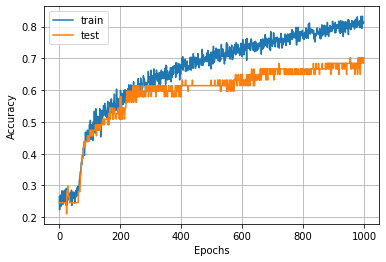

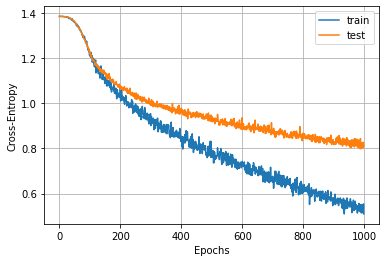


Resultados:
loss: [1.0244976487653008, 0.6350456455658222, 0.5727630586459719, 0.768426068897905, 0.967614603453669, 0.5087405247934933, 0.6772470265104059, 0.812890580871649, 0.5585186899754039, 0.8110065847112421]
accuracy: [0.5517241358757019, 0.7758620977401733, 0.7931034564971924, 0.6896551847457886, 0.6379310488700867, 0.7931034564971924, 0.719298243522644, 0.6842105388641357, 0.7543859481811523, 0.7017543911933899]
kappa: [0.4001591089896579, 0.7011494252873562, 0.7239190797302657, 0.5850556438791733, 0.5181962025316456, 0.724901185770751, 0.6254620123203285, 0.580539656582175, 0.6725482150184653, 0.6027060270602707]
Tiempo: 6169.500071287155


In [22]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D_LSTM_TD()
  
  history = model.fit(x_train, y_train, epochs=1000, batch_size=18,
                      validation_data=(x_test, y_test),
                      verbose=0, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
print("Tiempo:", fin - inicio)

In [23]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_82 (TimeDis (None, 1, 350, 123, 32)   320       
_________________________________________________________________
time_distributed_83 (TimeDis (None, 1, 175, 61, 32)    0         
_________________________________________________________________
time_distributed_84 (TimeDis (None, 1, 173, 59, 32)    9248      
_________________________________________________________________
time_distributed_85 (TimeDis (None, 1, 86, 29, 32)     0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 1, 84, 27, 32)     9248      
_________________________________________________________________
time_distributed_87 (TimeDis (None, 1, 42, 13, 32)     0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 1, 40, 11, 32)   

In [24]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.7101
std: (+/- 0.0718)
Mean Kappa: 0.6135
std: (+/- 0.0962)
Max Accuracy: 0.7931
Max Kappa: 0.7249


In [25]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 19 17:53:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   4717MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  